In [9]:
import pandas as pd
from biodatatools.utils.common import json_dump
import json
import subprocess
from collections import defaultdict
from biodata.delimited import DelimitedReader, DelimitedWriter
from mphelper import ProcessWrapPool
import gzip
from Bio import AlignIO
from collections import Counter
import requests
import re
import requests
from bs4 import BeautifulSoup
from urllib.parse import unquote
import subprocess
import os
import urllib.request
import pybedtools
import itertools

In [11]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_r2 = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/"

# Cell line related data

## K562

### ENCODE data

#### Epigenomic features

In [12]:
# Pick the files used to generate cCRE

df_info = pd.read_excel(f"{PROJECT_DIR_r}ENCODE/V4_cCREs.xlsx", header=2, sheet_name=1)
df_info.head(2)

,cCRE File,Biosample Slim,Biosample type,Organ,Biosample summary + donor,Experiment,BigWig,Experiment.1,BigWig.1,Experiment.2,BigWig.2,Experiment.3,BigWig.3
0,ENCFF296DEO_ENCFF521JLW_ENCFF247PMT.bed.gz,SK-N-MC,cell line,brain; epithelium,Homo_sapiens_SK-N-MC_ENCDO000ABC,ENCSR000EPY,ENCFF296DEO,ENCSR000DXL,ENCFF521JLW,ENCSR835MMN,ENCFF247PMT,---,---
1,ENCFF713HCD_ENCFF630TBW_ENCFF812BUV.bed.gz,astrocyte of the cerebellum,primary cell,brain,Homo_sapiens_astrocyte_of_the_cerebellum_ENCDO...,ENCSR000ENC,ENCFF713HCD,ENCSR000DSY,ENCFF630TBW,---,---,ENCSR000DSZ,ENCFF812BUV


In [15]:
# Use wild-type
# Experiment: DNase-seq
# Experiment.1: H3K4me3 ChIP-seq
# Experiment.2: H3K27ac ChIP-seq
# Experiment.3: CTCF ChIP-seq

df_info[df_info["Biosample Slim"]=="K562"]

,cCRE File,Biosample Slim,Biosample type,Organ,Biosample summary + donor,Experiment,BigWig,Experiment.1,BigWig.1,Experiment.2,BigWig.2,Experiment.3,BigWig.3
10,ENCFF414OGC_ENCFF806YEZ_ENCFF849TDM_ENCFF736UD...,K562,cell line,blood; bodily fluid,Homo_sapiens_K562_ENCDO000AAD,ENCSR000EOT,ENCFF414OGC,ENCSR000EWA,ENCFF806YEZ,ENCSR000AKP,ENCFF849TDM,ENCSR000BPJ,ENCFF736UDR
142,ENCFF929ROI.bed.gz,K562,cell line,blood; bodily fluid,Homo_sapiens_K562_treated_with_1_μM_vorinostat...,ENCSR000EKN,ENCFF929ROI,---,---,---,---,---,---
790,ENCFF625OEG.bed.gz,K562,cell line,blood; bodily fluid,Homo_sapiens_K562_treated_with_500_μM_sodium_b...,ENCSR000EKR,ENCFF625OEG,---,---,---,---,---,---
860,ENCFF132BMD.bed.gz,K562,cell line,blood; bodily fluid,Homo_sapiens_K562_treated_with_0.05%_dimethyl_...,ENCSR000EKO,ENCFF132BMD,---,---,---,---,---,---
867,ENCFF334FEV.bed.gz,K562,cell line,blood; bodily fluid,Homo_sapiens_K562_G2_phase_ENCDO000AAD,ENCSR000EKP,ENCFF334FEV,---,---,---,---,---,---
871,ENCFF503WXT.bed.gz,K562,cell line,blood; bodily fluid,Homo_sapiens_K562_G1_phase_ENCDO000AAD,ENCSR000EKQ,ENCFF503WXT,---,---,---,---,---,---


In [3]:
# DNase-seq 
# ENCSR000EOT
# https://www.encodeproject.org/files/ENCFF414OGC/@@download/ENCFF414OGC.bigWig
# https://www.encodeproject.org/files/ENCFF185XRG/@@download/ENCFF185XRG.bed.gz
# https://www.encodeproject.org/files/ENCFF205FNC/@@download/ENCFF205FNC.bam

# H3K27ac ChIP-seq
# ENCSR000AKP
# https://www.encodeproject.org/files/ENCFF849TDM/@@download/ENCFF849TDM.bigWig
# rep1: https://www.encodeproject.org/files/ENCFF121RHF/@@download/ENCFF121RHF.bam
# rep2: https://www.encodeproject.org/files/ENCFF907MNY/@@download/ENCFF907MNY.bam

#### Hi-C

In [ ]:
# rep1/2: https://www.encodeproject.org/files/ENCFF621AIY/@@download/ENCFF621AIY.hic

#### RNA-seq

In [ ]:
# Get processed TPM file from the ABC model github
# https://raw.githubusercontent.com/broadinstitute/ABC-Enhancer-Gene-Prediction/refs/heads/master/example_chr22/input_data/Expression/K562.ENCFF934YBO.TPM.txt

#### TF ChIP-seq

In [11]:
# A convenient way to fetch ENCODE search results. In the search terms, use "type":"Experiment" to search for experiment, or "type":"File" to search for file.

def ENCODE_search(search_terms={}, ENCODE_URL="https://www.encodeproject.org/", released=True):
	headers = {'accept': 'application/json'}
	values = {"limit": "all",
			  "format": "json",
			  "status": "released"
			 }
	values.update(**search_terms)
	data = urllib.parse.urlencode(values, safe="/")
	url = ENCODE_URL + "search/?" + data
	req = urllib.request.Request(url, headers=headers)
	try:
		with urllib.request.urlopen(req) as response:
			return json.loads(response.read().decode("ascii"))
	except urllib.error.HTTPError as e:
		print(values["dataset"])

In [4]:
def ENCODE_parse_search_results(search_results, return_func=lambda k: k, filter_func=None):
	results_list = []
	
	for search_result in search_results["@graph"]:
		if filter_func is not None:
			if not filter_func(search_result):
				continue
		result = return_func(search_result)
		results_list.append(result)
		
	return results_list

In [12]:
# Get ENCODE experiment ID

search_results = ENCODE_search({"type":"Experiment", "assay_title": "TF ChIP-seq", "biosample_ontology.term_name": "K562"})
expt_ids = ENCODE_parse_search_results(search_results, 
									  return_func=lambda sr: sr["@id"],
									  filter_func=lambda sr: sr["biosample_summary"] == "Homo sapiens K562")
len(expt_ids)

430

In [13]:
# Get metainfo for peak files
# ENCODE4: "IDR thresholded peaks"

srs = {}
for expt_id in expt_ids:
	search_results = ENCODE_search({"type":"File", "dataset":expt_id, "assembly":"GRCh38", "output_type":"IDR thresholded peaks"})
	srs[expt_id] = search_results

/experiments/ENCSR000EHA/


In [14]:
# Manually check this ENCSR000EHA dataset in ENCODE portal
# Only ENCODE3 version available: "optimal IDR thresholded peaks"

expt_id = "/experiments/ENCSR000EHA/"
search_results = ENCODE_search({"type":"File", "dataset":expt_id, "assembly":"GRCh38", "output_type":"optimal IDR thresholded peaks"})
srs[expt_id] = search_results

In [15]:
# ENCODE 4
# Replicates: /analysis-step-versions/tf-chip-seq-pooled-pseudoreplicated-idr-step-v-1-0/
# No replicates: /analysis-step-versions/tf-chip-seq-pseudoreplicated-idr-step-v-1-0/
# ENCODE 3
# /analysis-step-versions/tf-idr-step-v-1-0/

target_maps = {}
for expt_id, search_results in srs.items():
	if expt_id == "/experiments/ENCSR000EHA/":
		pipelines = ["/analysis-step-versions/tf-idr-step-v-1-0/"]
	else:
		pipelines = ["/analysis-step-versions/tf-chip-seq-pooled-pseudoreplicated-idr-step-v-1-0/",
					 "/analysis-step-versions/tf-chip-seq-pseudoreplicated-idr-step-v-1-0/"
					]
	for pipeline in pipelines:
		x = ENCODE_parse_search_results(search_results, 
									  return_func = lambda sr:(sr["target"]["label"], sr["href"], sr["biological_replicates"]),
									  filter_func = lambda sr: sr["analysis_step_version"]['@id'] == pipeline)
		if len(x) > 0:
			target_maps[expt_id] = x
			break

In [16]:
acc_target = {}
for expt_id in target_maps:
	target = target_maps[expt_id][0][0]
	acc = target_maps[expt_id][0][1].split("/")[2]
	acc_target[acc] = target

In [17]:
# Some targets have multiple ChIP-seq datasets available

len(acc_target), len(set(acc_target.values()))

(430, 310)

In [47]:
# Download all files
# https://www.encodeproject.org/help/batch-download/
# xargs -n 1 curl -O -L < download_ChIP.txt

outputfile = f"{PROJECT_DIR_r}ENCODE/download_ChIP_bed.txt"
with DelimitedWriter(outputfile) as dw:
	for expt_id in target_maps:
		dw.write([f"https://www.encodeproject.org{target_maps[expt_id][0][1]}"])

In [21]:
# Get metainfo for bigwig files

srs2 = {}
for expt_id in expt_ids:
	search_results = ENCODE_search({"type":"File", "dataset":expt_id, "assembly":"GRCh38", "output_type":"fold change over control"})
	srs2[expt_id] = search_results

In [43]:
# ENCODE 4
# Replicates: /analysis-step-versions/tf-chip-pooled-signal-generation-step-v-1-0/
# No replicates: /analysis-step-versions/tf-chip-signal-generation-step-v-1-0/
# ENCODE 3
# /analysis-step-versions/tf-macs2-signal-calling-step-v-1-1/: manually checked if pooled version available

target_maps2 = {}
for expt_id, search_results in srs2.items():
	if expt_id == "/experiments/ENCSR000EHA/":
		pipelines = ["/analysis-step-versions/tf-macs2-signal-calling-step-v-1-1/"]
	else:
		pipelines = ["/analysis-step-versions/tf-chip-pooled-signal-generation-step-v-1-0/",
					 "/analysis-step-versions/tf-chip-signal-generation-step-v-1-0/"
					]
	for pipeline in pipelines:
		x = ENCODE_parse_search_results(search_results, 
									  return_func = lambda sr:(sr["target"]["label"], sr["href"], sr["biological_replicates"]),
									  filter_func = lambda sr: sr["analysis_step_version"]['@id'] == pipeline)
		if expt_id == "/experiments/ENCSR000EHA/":
			# pooled
			target_maps2[expt_id] = [i for i in x if len(i[-1])==2]

		else:
			if len(x) > 0:
				target_maps2[expt_id] = x
				break

In [45]:
acc_target2 = {}
outputfile = f"{PROJECT_DIR_r}ENCODE/download_ChIP_bw.txt"
with DelimitedWriter(outputfile) as dw:
	for expt_id in target_maps2:
		target = target_maps2[expt_id][0][0]
		href = target_maps2[expt_id][0][1]
		dw.write([f"https://www.encodeproject.org{href}"])
		acc = href.split("/")[2]
		acc_target2[acc] = target

In [46]:
json_dump(f"{PROJECT_DIR_r}ENCODE/acc_target.json", acc_target)
json_dump(f"{PROJECT_DIR_r}ENCODE/acc_target_bw.json", acc_target2)

### Other source

#### CRISPR

In [ ]:
# A K562 CRISPR benchmarking dataset generated from combining results from different published experiments
# https://github.com/EngreitzLab/CRISPR_comparison/blob/main/resources/crispr_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz

## HCT116

### ENCODE data

In [16]:
# Use wild-type

df_info[df_info["Biosample Slim"]=="HCT116"]

,cCRE File,Biosample Slim,Biosample type,Organ,Biosample summary + donor,Experiment,BigWig,Experiment.1,BigWig.1,Experiment.2,BigWig.2,Experiment.3,BigWig.3
48,ENCFF431JDU_ENCFF964OOU_ENCFF787LMI_ENCFF388PV...,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_ENCDO000ABE,ENCSR000ENM,ENCFF431JDU,ENCSR000DTQ,ENCFF964OOU,ENCSR661KMA,ENCFF787LMI,ENCSR000DTO,ENCFF388PVO
965,ENCFF623IQZ_ENCFF209JIH_ENCFF937FKH.bed.gz,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_genetically_modified_inser...,ENCSR498JAW,ENCFF623IQZ,ENCSR287XHR,ENCFF209JIH,ENCSR873SVP,ENCFF937FKH,---,---
966,ENCFF246BAU_ENCFF457FEX_ENCFF742ERW.bed.gz,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_genetically_modified_inser...,ENCSR542UWN,ENCFF246BAU,ENCSR331GZV,ENCFF457FEX,ENCSR138ITT,ENCFF742ERW,---,---
967,ENCFF609EOJ_ENCFF838KNK_ENCFF426ZES.bed.gz,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_genetically_modified_inser...,ENCSR694YJR,ENCFF609EOJ,ENCSR787WSK,ENCFF838KNK,ENCSR709PFC,ENCFF426ZES,---,---
968,ENCFF051XFM_ENCFF642BED_ENCFF448FEB.bed.gz,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_genetically_modified_inser...,ENCSR867ITQ,ENCFF051XFM,ENCSR718JUS,ENCFF642BED,ENCSR743HTN,ENCFF448FEB,---,---
977,ENCFF136DSS_ENCFF547MNW_ENCFF008HLE.bed.gz,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_genetically_modified_inser...,ENCSR690ADK,ENCFF136DSS,ENCSR581LUB,ENCFF547MNW,ENCSR108CCH,ENCFF008HLE,---,---
978,ENCFF656TCI_ENCFF370MPF_ENCFF100CVT.bed.gz,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_genetically_modified_inser...,ENCSR795ZKB,ENCFF656TCI,ENCSR197PUB,ENCFF370MPF,ENCSR991JSQ,ENCFF100CVT,---,---
979,ENCFF559HJK_ENCFF190GZS_ENCFF729LUC.bed.gz,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_genetically_modified_inser...,ENCSR163KCQ,ENCFF559HJK,ENCSR191ULN,ENCFF190GZS,ENCSR324ZNP,ENCFF729LUC,---,---
980,ENCFF241EHU_ENCFF442UOG_ENCFF301DSI.bed.gz,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_genetically_modified_inser...,ENCSR702VYW,ENCFF241EHU,ENCSR098CPV,ENCFF442UOG,ENCSR671XCL,ENCFF301DSI,---,---
981,ENCFF635GBA_ENCFF282JSU_ENCFF995AGX.bed.gz,HCT116,cell line,colon; epithelium; intestine; large intestine,Homo_sapiens_HCT116_genetically_modified_inser...,ENCSR799GSS,ENCFF635GBA,ENCSR809YOX,ENCFF282JSU,ENCSR571CNF,ENCFF995AGX,---,---


In [ ]:
# DNase-seq
# ENCSR000ENM
# https://www.encodeproject.org/files/ENCFF240LRP/@@download/ENCFF240LRP.bed.gz

# CTCF ChIP-seq
# ENCSR000DTO
# https://www.encodeproject.org/files/ENCFF388PVO/@@download/ENCFF388PVO.bigWig
# https://www.encodeproject.org/files/ENCFF832INR/@@download/ENCFF832INR.bed.gz

# RAD21 ChIP-seq
# https://www.encodeproject.org/files/ENCFF776IXR/@@download/ENCFF776IXR.bigWig

In [ ]:
# CTCF ChIA-PET
# https://www.encodeproject.org/files/ENCFF431BUN/@@download/ENCFF431BUN.bedpe.gz
# Ruan lab ChIA-PET pipeline: https://www.encodeproject.org/pipelines/ENCPL169TBL/
# Produce loop (bedpe) file: First, ChIA-PIPE filters out inter-chromosomal contacts and self-ligation PETs with genomic span less than 8 kbp. Then, the 5’ end of each inter-ligation PET is extended by 500 bp along the reference genome, which makes chromatin fragments closer to the actual protein binding position in DNA. Finally, ChIA-PIPE merges overlapping extended inter-ligation PETs into a cluster with the number of overlapped inter-ligation PET as a PET count of the loop. Loops with PET count =1 are called singletons and they filter them out to retain only highly confident frequent loops.

# Hi-C
# https://www.encodeproject.org/files/ENCFF573OPJ/@@download/ENCFF573OPJ.hic

### Other source

#### CTCF ChIP-seq

In [ ]:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE179545

In [ ]:
# CTCF ChIP-seq for degron lines
# For inducing auxin-inducible degron system, 500μM 3-indole acetic acid was treated for 6 hours.
# CTCF Auxin- rep1: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM5420199
# CTCF Auxin+ rep1: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM5420200
# CPM normalized bigwig, hg19

In [13]:
def get_geo_links(gsm_ids):
	for gsm_id in gsm_ids:
		url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={gsm_id}" 
		r = requests.get(url) 
		soup = BeautifulSoup(r.text, "html.parser") 
		table = soup.find("table", string=lambda s: s and "Supplementary file" in s) 
		if table is None: 
			table = soup.find("table") 
		for row in table.find_all("tr")[1:]: 
			cells = row.find_all("td") 
			if len(cells) < 3: 
				continue 
			file_name = cells[0].text.strip() 
			link_tag = cells[2].find("a", href=True) 
			if link_tag: 
				ftp_link = unquote(link_tag['href']) 
				if ftp_link.startswith("ftp://"):
					# Download FTP files in our server 01
					print(f"wget {ftp_link}")

In [60]:
get_geo_links(["GSM5420199", "GSM5420200"])

wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5420nnn/GSM5420199/suppl/GSM5420199_I_Con_CTCF.bw
wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5420nnn/GSM5420200/suppl/GSM5420200_I_IAA_CTCF.bw


In [134]:
def bw_liftover(bw_in, bw_out, unlifted_file, chain_file, chrom_sizes):
	commands = ["bwtool lift",
			bw_in,
			chain_file,
			bw_out,
			f"-sizes={chrom_sizes}",
			f"-unlifted={unlifted_file}"]
	subprocess.run(" ".join(commands), shell=True)

In [11]:
ids = ["GSM5420199_I_Con", "GSM5420200_I_IAA"]
chrom_sizes = f"{PROJECT_DIR_r}genomes/human/hg38.chrom.sizes"
chain_file = f"{PROJECT_DIR_r}genomes/human/hg19ToHg38.over.chain.gz"

In [ ]:
# We just used this for visualization in browser shots; no need to reprocess raw data
# Liftover to hg38

pwpool = ProcessWrapPool(len(ids))
for i in ids:
	bw_in = f"{PROJECT_DIR_r}other/GSE179545/{i}_CTCF.bw"
	bw_out = f"{PROJECT_DIR_r}other/GSE179545/{i}_CTCF_hg38.bw"
	unlifted_file = f"{PROJECT_DIR_r}other/GSE179545/{i}_CTCF_hg38_unmapped.bed"
	pwpool.run(bw_liftover, args=[bw_in, bw_out, unlifted_file, chain_file, chrom_sizes])

In [28]:
len(pwpool.finished_tasks)

2

In [29]:
pwpool.close()

## HEK293T

### Accessibility

In [14]:
# Experiment: DNase-seq

df_info[df_info["Biosample Slim"]=="HEK293T"]

,cCRE File,Biosample Slim,Biosample type,Organ,Biosample summary + donor,Experiment,BigWig,Experiment.1,BigWig.1,Experiment.2,BigWig.2,Experiment.3,BigWig.3
42,ENCFF529BOG.bed.gz,HEK293T,cell line,epithelium; kidney,Homo_sapiens_HEK293T_ENCDO000ABF,ENCSR000EJR,ENCFF529BOG,---,---,---,---,---,---


In [ ]:
# DNase-seq 
# ENCSR000EJR
# Extremely low spot score; this quality (0.23); any sample with a SPOT1 score <0.3 should be targeted for replacement with a higher quality sample; so we chose not to use this dataset

In [5]:
# Obtain ATAC-seq data from GSE266490 (Dong et al. NAR. 2025)
# https://github.com/guertinlab/znf143_degron/blob/main/ATAC_analysis/Combined_ATAC_peak_counts.txt
# This file contains all ATAC-seq peaks from samples before and after treatment
# We'll filter ATAC-seq peaks with our PRO-cap elements identified in untreated state.

inputfile = f"{PROJECT_DIR_r}other/GSE266490/Combined_ATAC_peak_counts.txt"
df = pd.read_table(inputfile)
outputfile = f"{PROJECT_DIR_r}other/GSE266490/Combined_ATAC_peaks.bed.gz"
with DelimitedWriter(outputfile) as dw:
	for _, row in df.iterrows():
		dw.write([row["chr"], row["start"], row["end"]])

In [12]:
# PRO-cap elements (untreated) have decent overlapping ratios with these ATAC-seq peaks

s = "HEK293T"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
results = []
b1 = pybedtools.BedTool(f"{PROJECT_DIR_r}other/GSE266490/Combined_ATAC_peaks.bed.gz")
for p, d in itertools.product(ps, ds):
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_pd/{s}_{p}_{d}.bed")
	results.append([f"{p.capitalize()}_{d}", len(b2), round(len(b2.intersect(b1, u=True))/len(b2),2)])
pd.DataFrame(results, columns=["Group", "Total No. elements", "Fraction of elements overlapping with ATAC-seq peaks"])

,Group,Total No. elements,Fraction of elements overlapping with ATAC-seq peaks
0,Divergent_distal,8735,0.82
1,Divergent_proximal,24505,0.87
2,Unidirectional_distal,10037,0.59
3,Unidirectional_proximal,6392,0.57


### ZNF143 ChIP-seq

In [ ]:
# Obtain ZNF143 ChIP-seq data from GSE266489 (Dong et al. NAR. 2025)
# GSE266489_antiZNF143_ChIP2_summits.bed.gz
# GSE266489_antiZNF143-control_merged_normalized.bigWig
# GSE266489_antiZNF143-dTAG_merged_normalized.bigWig

# Other data

## Mappability

In [ ]:
# Paper: https://academic.oup.com/nar/article/46/20/e120/5086676

# k24
# http://hgdownload.soe.ucsc.edu/gbdb/hg38/hoffmanMappability/k24.Umap.MultiTrackMappability.bw
# k36
# http://hgdownload.soe.ucsc.edu/gbdb/hg38/hoffmanMappability/k36.Umap.MultiTrackMappability.bw
# k50
# http://hgdownload.soe.ucsc.edu/gbdb/hg38/hoffmanMappability/k50.Umap.MultiTrackMappability.bw

## phyloP

In [12]:
# http://hgdownload.cse.ucsc.edu/goldenPath/hg38/phyloP100way/hg38.phyloP100way.bw

## CTDS

In [ ]:
# Paper: https://www.nature.com/articles/s41588-018-0062-7
# The files were downloaded through the links below a few years ago; Unfortunately, these links are no longer active...
# http://www.hli-opendata.com/noncoding/README_noncoding_HLIopendata_20171019.txt
# http://www.hli-opendata.com/noncoding/coord_CDTS_percentile_N7794unrelated.txt.gz

In [23]:
f1 = f"{PROJECT_DIR_r}other/CDTS/coord_CDTS_percentile_N7794unrelated.txt.gz"
! zcat $f1 | head -n 2 2>/dev/null

chromosome	start	end	CDTS	percentile
chr1	821620	821630	-2.76477	29

gzip: stdout: Broken pipe


In [24]:
# txt --> bedGraph

f2 = f"{PROJECT_DIR_r}other/CDTS/coord_CDTS_percentile_N7794unrelated.bg"
commands = f"zcat {f1} | awk -v OFS='\\t' 'NR>1 {{print $1,$2,$3,$4}}' > {f2}"
subprocess.run(commands, shell=True, check=True)

CompletedProcess(args="zcat /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/other/CDTS/coord_CDTS_percentile_N7794unrelated.txt.gz | awk -v OFS='\\t' 'NR>1 {print $1,$2,$3,$4}' > /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/other/CDTS/coord_CDTS_percentile_N7794unrelated.bg", returncode=0)

In [15]:
# bedGraph --> bw

chrom_sizes = f"{PROJECT_DIR_r}genomes/human/hg38.chrom.sizes.filtered"
f3 = f"{PROJECT_DIR_r}other/CDTS/coord_CDTS_percentile_N7794unrelated.bw"
! bedGraphToBigWig $f2 $chrom_sizes $f3

## Age

In [ ]:
# Syntenic aging strategy: refer to https://academic.oup.com/mbe/article/38/9/3681/6273355

### Clade timing

In [19]:
# MYA: million years ago

clades = {"None": "NA",
		  "Homo_sapiens": 0,
		  "Primate": 72,
		  "Euarchontoglires": 90,
		  "Boreoeutheria": 96,
		  "Eutheria": 105,
		  "Theria": 159,
		  "Mammalia": 177,
		  "Amniote": 312,
		  "Tetrapod": 352,
		  "Vertebrate": 615}

In [26]:
json_dump(f"{PROJECT_DIR_r}other/age/clades.json", clades)

### Group species into 10 clades

Here age categories are marked in yellow and the name of subsets in multiz100way-README.txt are marked in red.

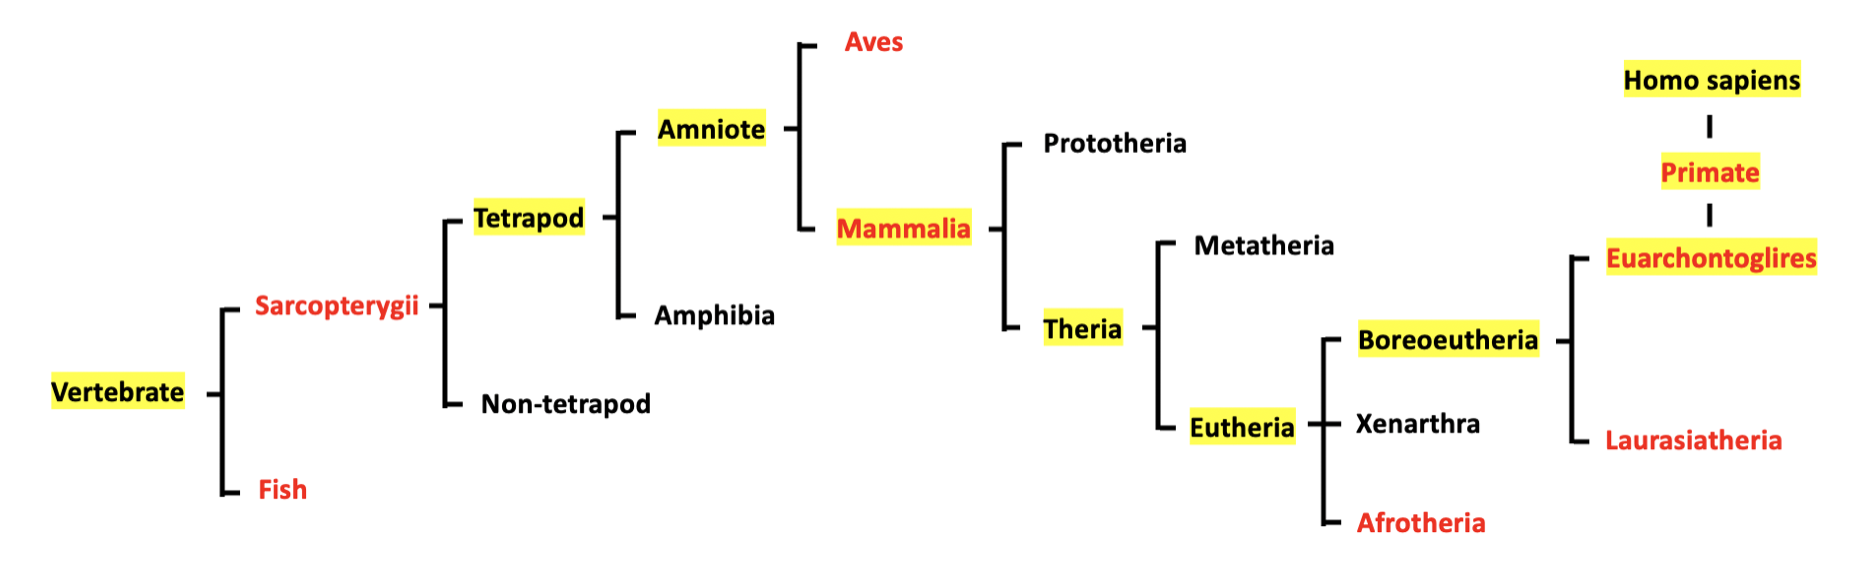

In [64]:
# http://hgdownload.cse.ucsc.edu/goldenPath/hg38/multiz100way/README.txt

inputfile = f"{PROJECT_DIR_r2}UCSC/multiz100way/hg38/README.txt"
temp = defaultdict(set)
versions = {}
with DelimitedReader(inputfile) as dr:
	for cols in dr:
		if "==" in cols[0]:
			# e.g., Primate
			category = cols[0].split()[1]
		if len(cols[0]) > 100:
			# e.g., Human
			species = cols[0][:24].strip()
			# e.g., "hg38"
			version = cols[0][66:112].strip().split("/")[-1]
			versions[version] = species
			temp[category].add(species)

In [65]:
# Re-organize the categories

categories = defaultdict(set)

In [66]:
categories["Homo_sapiens"] = {"Human"}
for k in temp["Primate"]:
	if k != "Human":
		categories["Primate"].add(k)
categories["Euarchontoglires"] = temp["Euarchontoglires"]
categories["Boreoeutheria"] = temp["Laurasiatheria"]
categories["Eutheria"] = temp["Afrotheria"]

In [71]:
# Divide "Mammal" into three categories
# "Armadillo": Xenarthra - Eutheria
# "Opossum", "Tasmanian devil", "Wallaby": Metatheria - Theria
# "Platypus": Prototheria - Mammalia

categories["Eutheria"].add("Armadillo")
categories["Theria"] = {"Opossum", "Tasmanian devil", "Wallaby"}
categories["Mammalia"] = {"Platypus"}
categories["Amniote"] = temp["Aves"]

In [75]:
# Divide "Sarcopterygii" into tetrapod and non-tetrapod
# "American alligator": tetrapod
# "Chinese softshell turtle": tetrapod
# "Coelacanth": non-tetrapod
# "Green seaturtle": tetrapod
# "Lizard": tetrapod
# "Painted turtle": tetrapod
# "Spiny softshell turtle": tetrapod
# "X. tropicalis": tetrapod

for k in temp["Sarcopterygii"]:
	if k != "Coelacanth":
		categories["Tetrapod"].add(k)
categories["Vertebrate"] = temp["Fish"]
categories["Vertebrate"].add("Coelacanth")

In [80]:
categories = defaultdict(list, {key: list(value) for key, value in categories.items()})
json.dump(f"{PROJECT_DIR_r}other/age/MRCA_categories_100way.json", categories)

### Get syntenic blocks

In [ ]:
# http://hgdownload.cse.ucsc.edu/goldenpath/hg38/multiz100way/maf/
# The maf/chr*.maf.gz files each contain all the alignments to that particular human chromosome, with additional annotations to indicate gap context, and genomic breaks for the sequence in the underlying genome assemblies.

In [89]:
# Each syntenic block was assigned an age based on the most recent common ancestor (MRCA) of the species present in the alignment block of the UCSC species tree model.

def get_syntenic_blocks(inputfile, outputfile, clades):
	with DelimitedWriter(outputfile) as dw:
		with gzip.open(inputfile, "rt") as f:
			for multiple_alignment in AlignIO.parse(f, "maf"):
				all_species = []
				for seqrec in multiple_alignment:
					version = seqrec.id.split(".")[0]
					category = categories[versions[version]]
					all_species.append(clades.index(category))
					if version == "hg38":
						# 0-based
						start = seqrec.annotations["start"]
						size = seqrec.annotations["size"]
						strand = seqrec.annotations["strand"]
						srcSize = seqrec.annotations["srcSize"]
						chrom = seqrec.id.split(".")[1]
						# "+" strand
						if strand == 1:
							end = start + size
						# "-" strand: http://genomewiki.ucsc.edu/index.php/Coordinate_Transforms
						else:
							start_temp = start
							end_temp = start_temp + size
							start = srcSize - end_temp
							end = srcSize - start_temp
				age = clades[max(all_species)]
				dw.write([chrom, start, end, age])

In [425]:
chroms = [f"chr{n}" for n in range(1, 23)]
chroms.extend(["chrX"])

In [90]:
pwpool = ProcessWrapPool(len(chroms))

for chrom in chroms:
	inputfile = f"{PROJECT_DIR_r2}/UCSC/multiz100way/hg38/{chrom}.maf.gz"
	outputfile = f"{PROJECT_DIR_r2}/UCSC/multiz100way/hg38/{chrom}.bed"
	pwpool.run(get_syntenic_blocks, args=[inputfile, outputfile, list(clades.keys())])

In [86]:
len(pwpool.finished_tasks)

23

In [87]:
pwpool.close()

## TE

In [15]:
# https://repeatmasker.org/genomes/hg38/RepeatMasker-rm405-db20140131/hg38.fa.out.gz
# hg38 - Dec 2013 - RepeatMasker open-4.0.5 - Repeat Library 20140131

In [406]:
# Convert the file into tab-delimited file

inputfile = f"{PROJECT_DIR_r}other/rmsk/hg38.fa.out.gz"
outputfile = f"{PROJECT_DIR_r}other/rmsk/hg38.fa.tbl.gz"
with DelimitedWriter(outputfile) as dw:
	dw.write(["SW score", "perc div.", "perc del.", "perc ins.", "genoName", "genoStart", "genoEnd", "genoLeft", 
			  "strand", "repName", "repClass", "repFamily", "repStart", "repEnd", "repLeft", "id"])
	with DelimitedReader(inputfile) as dr:
		for cols in dr:
			if "SW" not in cols[0] and "score" not in cols[0]:
				cols2 = cols[0].split(" ")
				cols2 = [c for c in cols2 if c != ""]
				# strand
				if cols2[8] == "C":
					cols2[8] = "-"
				if "/" in cols2[10]:
					repClass, repFamily = cols2[10].split("/")
				else:
					repClass = cols2[10]
					repFamily = cols2[10]
				cols_final = cols2[:10] + [repClass, repFamily] + cols2[12:]
				dw.write(cols_final)

In [25]:
df_all = pd.read_table(f"{PROJECT_DIR_r}other/rmsk/hg38.fa.tbl.gz")
df_all.head(2)

,SW score,perc div.,perc del.,perc ins.,genoName,genoStart,genoEnd,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
0,463,1.3,0.6,1.7,chr1,10001,10468,(248945954),+,(TAACCC)n,Simple_repeat,Simple_repeat,463,(0),1.0,NaN
1,4005,11.3,21.5,1.3,chr1,10469,11447,(248944975),-,TAR1,Satellite,telo,1712,483,2.0,NaN


In [429]:
# https://genome.ucsc.edu/cgi-bin/hgTrackUi?g=rmsk
# A "?" at the end of the "Family" or "Class" (for example, DNA?) signifies that the curator was unsure of the classification. At some point in the future, either the "?" will be removed or the classification will be changed.

Counter(df_all["repClass"])

Counter({'SINE': 1861482,
         'LINE': 1609790,
         'LTR': 763158,
         'Simple_repeat': 700455,
         'DNA': 536363,
         'Low_complexity': 103244,
         'LTR?': 8525,
         'Satellite': 7918,
         'Unknown': 6523,
         'Retroposon': 5827,
         'snRNA': 4537,
         'DNA?': 4383,
         'tRNA': 2066,
         'scRNA': 1931,
         'rRNA': 1861,
         'RC': 1822,
         'srpRNA': 1428,
         'RNA': 762,
         'RC?': 435,
         'SINE?': 6})

In [426]:
TEclass = ["SINE", "LINE", "LTR", "DNA"]

In [427]:
target_cols = ["genoName", "genoStart", "genoEnd", "strand", "repName", "repClass", "repFamily", "perc div."]
df_filtered = df_all[df_all["repClass"].isin(TEclass) & df_all["genoName"].isin(chroms)][target_cols]
df_filtered.columns = [i for i in range(len(target_cols))]
df_filtered.head(2)

,0,1,2,3,4,5,6,7
2,chr1,11485,11676,-,L1MC5a,LINE,L1,21.2
3,chr1,11678,11780,-,MER5B,DNA,hAT-Charlie,29.4


In [428]:
len(df_all), len(df_filtered)

(5622516, 4565530)

In [414]:
outputfile = f"{PROJECT_DIR_r}other/rmsk/TE_filtered.bed.gz"
df_filtered.to_csv(outputfile, sep="\t", index=False, header=False)

## LOEUF

In [ ]:
# https://gnomad.broadinstitute.org/help/constraint#loeuf 
# https://storage.googleapis.com/gcp-public-data--gnomad/release/4.1/constraint/gnomad.v4.1.constraint_metrics.tsv

## Promoter classification

In [ ]:
# https://www.nature.com/articles/s41586-022-04877-w
# https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-022-04877-w/MediaObjects/41586_2022_4877_MOESM9_ESM.txt

## JASPAR

In [ ]:
# JASPAR
# https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt

In [31]:
def get_motif_file(motifs, inputfile, outputfile):
	with open(inputfile, "r") as f:
	    content = f.read()

	with open(outputfile, "w") as f:
		infos = content.split("MOTIF ")
		# header
		f.write(infos[0])
		# motif matrix
		for k in infos[1:]:
			match = re.search(r"MA\d+\.\d+\s+(\S+)", k)
			if match.group(1) in motifs:
				f.write(f"MOTIF {k}")

In [96]:
motifs = ["CTCF"]
inputfile = f"{PROJECT_DIR_r}other/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt"
outputfile = f"{PROJECT_DIR_r}other/JASPAR/JASPAR2024_CORE_vertebrates_{motifs[0]}.txt"
get_motif_file(motifs, inputfile, outputfile)

In [35]:
# "JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt" only contains Thap11 (MA1573.2) from Mus musculus
# Add THAP11 (MA1573.1) from JASPAR website: https://jaspar.elixir.no/matrix/MA1573.1/
# Will add THAP11-ZNF143 composite motif from ProCapNet model

motifs = ["ZNF143"]
inputfile = f"{PROJECT_DIR_r}other/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt"
outputfile = f"{PROJECT_DIR_r}other/JASPAR/JASPAR2024_CORE_vertebrates_ZNF143.txt"
get_motif_file(motifs, inputfile, outputfile)

# Tools

In [ ]:
# For tools not listed in ".yml" files are shown below

## SVR model (TATA & DPR)

In [ ]:
# Paper: https://www.nature.com/articles/s41586-020-2689-7
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139635

## ProCapNet

In [ ]:
# https://github.com/kundajelab/nascent_RNA_models

## ABC model

In [ ]:
# https://github.com/broadinstitute/ABC-Enhancer-Gene-Prediction/tree/master
# https://abc-enhancer-gene-prediction.readthedocs.io/en/latest/usage/methods.html#defining-candidate-elements
# v1.1.1-30-gc08adc3

## CRISPR benchmark

In [ ]:
# https://github.com/EngreitzLab/CRISPR_comparison
# 96b94efe331b2330d4bf6061fc8b276c46286ec3

## FIMO

In [ ]:
# https://meme-suite.org/meme/meme-software/

In [128]:
! fimo --version

5.5.4


## bwtool

In [ ]:
# https://github.com/CRG-Barcelona/bwtool

In [2]:
! bwtool --version

bwtool 1.0
Copyright (C) 2015 Centre for Genomic Regulation (CRG) in Barcelona.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>.
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.

Written by Andy Pohl.


## statannotations

In [ ]:
# To be compatible with seaborn 0.13.2; https://github.com/trevismd/statannotations/pull/155
# pip install git+https://github.com/getzze/statannotations.git@compat-seaborn-13 --upgrade

## HiC-Pro

In [ ]:
# https://github.com/nservant/HiC-Pro
# v3.1.0

# FitHiChIP

In [ ]:
# https://github.com/ay-lab/FitHiChIP
# 11.0-9-g0ea1ac2